In [1]:
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

from sklearn.externals import joblib
from sklearn import linear_model, svm
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from scipy.special import expit

import datetime
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Читаем граф

Различные графы лежат в `data/graph`. Граф задан списком ребер, на каждой строке описывается ребро:
> 12 13 64

Первое и второе число `id` пользователя, третье - аттрибут ребра. 

In [7]:
def read_edges(f):        
    with codecs.open(f, 'r', encoding='utf-8') as fd:           
        edges = [tuple(int(x) for x in line.strip().split(' ')) for line in fd]
    
    return edges  


def make_graph(f):
    edges = read_edges(f)
    users = sorted(set([x1 for (f, t, w) in edges for x1 in (f, t)]))
    users = dict(zip(users, range(len(users))))

    edges = [(users[f], users[t], {'attr': w}) for (f, t, w) in edges]
    G = nx.Graph()
    G.add_edges_from(edges)
    
    return G, users

In [3]:
def calc_common_friends(G):
    common_friends = dict()
    for f, t in G.edges():
        if f < t:
            fr1 = set(G.neighbors(f))
            fr2 = set(G.neighbors(t))
            common_friends[(f, t)] = len(fr1 & fr2)
            
    return common_friends

In [8]:
import codecs

G, users = make_graph('data/graph/11858037.txt')
common_friends = calc_common_friends(G)        

Тут читаем файлы с демографическими данными пользователей

In [48]:
def read_demography(path, users):
    import glob, os
    all_files = glob.glob(os.path.join(path, "part-*")) 
    df = pd.concat((pd.read_csv(f, sep='\t', header=None) for f in all_files))
                   
    df.columns = ['user', 'create_date', 'birth_date', 'gender', 'country', 'loc', 'reg']
    df = df[df['user'].map(lambda x: x in users)]

    epoch = datetime.datetime.fromtimestamp(0)
    delta = datetime.timedelta(1)
    
    df['user'] = df['user'].map(lambda x: users[x])
    df['birth_date'] = df['birth_date'].map(lambda x: (epoch + int(x) * delta) if x == x else np.nan)
    df['birth_year'] = df[df['birth_date'].notnull()]['birth_date'].map(lambda x: x.year)
    df = df.set_index('user').sort_index()
    
    return df

In [49]:
demography = read_demography('data/demography/', users)

# 2.  Обучение similarity между пользователями

В функцию передается граф и данные по демографии. На выходе получается функция, которая по ребку выдает вектор с признаками. Последний элемент вектора - целевое значение. 

In [52]:
def features_factory(G, demography):
    common_friends = calc_common_friends(G)
    
    def test_bit(int_type, offset):
        mask = 1 << offset
        return bool(int_type & mask)
    
    def features_for_edge(edge):
        (f, t, w) = edge
        common = np.log(common_friends[(f, t)] + 1)

        if (f in demography.index) and (t in demography.index):
            (dem_f, dem_t) = demography.ix[f], demography.ix[t]
            is_same_year = np.abs(dem_f['birth_year'] - dem_t['birth_year']) < 2
            is_same_gender = dem_f['gender'] == dem_t['gender']
            is_same_loc = dem_f['loc'] == dem_t['loc']
        else:
            is_same_year = False
            is_same_gender = False
            is_same_loc = False

        is_same_univ = test_bit(w, 10) or test_bit(w, 14)
        is_relative = (test_bit(w, 3) or test_bit(w, 4) or test_bit(w, 18) 
                     or test_bit(w, 19) or test_bit(w, 12) or test_bit(w, 13))
        is_love = test_bit(w, 1)
        is_colleague = test_bit(w, 9)

        return [float (x) for x in [common, is_same_gender, is_same_loc, is_same_univ, is_relative, is_love]] + \
               [int(is_same_year)]
        
    return features_for_edge

**NB!** три следующие ячейки не запускать, в репозитории лежит уже натренированная модель

Подготавливаем данные

In [58]:
edges_to_train = []

for (f, t, w) in G.edges_iter(data=True):
    if (f in demography.index) and (t in demography.index):
        edges_to_train.append((f, t, w['attr']))
        
random.shuffle(edges_to_train)    
        
feature_maker = features_factory(G, demography)
data = np.asarray([feature_maker(edge) for edge in edges_to_train])

X = data[:, :-1]
y = data[:, -1]

Обучаем (нужно добавить CV по параметру регуляризации)

In [63]:
clf = linear_model.LogisticRegression()
pipeline = Pipeline([('scale', StandardScaler()), 
                     #('poly', PolynomialFeatures()),
                     ('clf', clf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)

roc_auc_score(y_test, y_predicted)
              #expit(X_test @ clf.coef_.reshape((-1, 1)) + clf.intercept_[0]))

0.60091430771831622

Сохраняем полученное

In [64]:
from sklearn.externals import joblib

joblib.dump(pipeline, 'data/linear_model.pkl') 

['data/linear_model.pkl',
 'data/linear_model.pkl_01.npy',
 'data/linear_model.pkl_02.npy',
 'data/linear_model.pkl_03.npy',
 'data/linear_model.pkl_04.npy',
 'data/linear_model.pkl_05.npy',
 'data/linear_model.pkl_06.npy',
 'data/linear_model.pkl_07.npy']

**NB!** отсюда можно запускать

# 3. Реализуем определение возраста

Делаем взвешиватель рёбер

In [65]:
def make_weighter(G, demography, model):
    make_features = features_factory(G, demography)
    
    def weighter(edge):
        features = np.array(make_features(edge)[:-1])
        return expit(model.decision_function(features.reshape(1, -1))[0])
   
    return weighter 

Первый класс - реализация semisupervised learning. Второй - определение атрибутов. 

In [66]:
class SemisupervisedClusterer(object):
    def __init__(self):
        pass
        
    def cluster(self, W, Y, alpha, sigma):            
        diag = np.asarray(W.sum(axis=0)).ravel()
        W_a = np.asarray(W)
        W_a = W_a * np.power(diag, -sigma).reshape((-1, 1))
        W_a = W_a * np.power(diag, sigma - 1.).reshape((1, -1))
        
        D = np.identity(len(W)) - alpha * W_a
        Y = (1. - alpha) * Y
  
        F = np.linalg.solve(D, Y)
        
        return np.asarray(F)

    
class SemisupervisedSolver(object):
    def __init__(self, G, demography, weighter):
        self.G = G
        self.demography = demography        
        self.weighter = weighter

    def prepare_matrices(self, labeled_nodes, year_to_id):
        G = self.G
        demography = self.demography
        
        labeled_nodes_set = set(labeled_nodes)

        W = np.zeros((G.number_of_nodes(), G.number_of_nodes()))
        Y = np.zeros((G.number_of_nodes(), len(year_to_id)))

        for f, t, data in G.edges(data=True):
            w = data['attr']
            if f < t: 
                if (f in labeled_nodes_set) and (t in labeled_nodes_set):
                    (year_f, year_t) = demography.ix[f]['birth_year'], demography.ix[t]['birth_year']
                    diff = np.abs(year_f - year_t)
                    W[t, f] = W[f, t] = 10. if diff < 5 else max(1. - diff / 10., 0.2) 
                else:
                    W[t, f] = W[f, t] = max(3. * self.weighter((f, t, w)), 0.1) 

        for node in labeled_nodes:
            birth_year = demography.ix[node]['birth_year']
            Y[node, year_to_id[birth_year]] = 1.

        return W, Y
    
    def predict(self, labeled_nodes, test_nodes):           
        demography = self.demography
        
        years = sorted(set(demography.ix[labeled_nodes, 'birth_year']))
        year_to_id = dict(zip(years, range(len(years))))
        id_to_year = dict(enumerate(years))        
        
        W, Y = self.prepare_matrices(labeled_nodes, year_to_id)
        clusterer = SemisupervisedClusterer()
                
        F = clusterer.cluster(W, Y, 0.75, 0.)
        
        predicted_years = np.array([id_to_year[x] for x in F[test_nodes].argmax(axis=1)])
        real_years = np.array(demography.ix[test_nodes, 'birth_year'])
        
        return predicted_years, real_years

Средний возраст среди друзей. Для сравнения.

In [67]:
class MeanAmongFriendsSolver(object):
    def __init__(self, G, demography):
        self.G = G
        self.demography = demography        

    def predict(self, labeled_nodes, test_nodes):
        G = self.G
        demography = self.demography
        labeled_nodes_set = set(labeled_nodes)
        
        avg = demography.ix[labeled_nodes, 'birth_year'].mean()
        
        predicted = []
        for test_node in test_nodes:
            lst = []
            for neigbor in G.neighbors(test_node):
                if neigbor in labeled_nodes_set:
                     lst.append(demography.ix[neigbor, 'birth_year'])
            predicted.append(np.mean(lst) if lst else avg) 
                 
        real_years = np.array(self.demography.ix[test_nodes, 'birth_year'])
        
        return np.array(predicted), real_years

Тесты:
1. Из всех пользователеё случайно выбираем помеченные и непомеченные в заданной пропорции (`pcrt`).
2. Запускаем процесс, смотрим что определили правильно и разницу.
3. Повторяем процесс с п.1 десять раз, запоминая результаты

In [68]:
def prepare_tests(num, prct, demography):
    tests = []
    for i in range(num):
        nodes_with_age = list(demography.index)
        random.shuffle(nodes_with_age)

        pivot = int(len(nodes_with_age) * prct)
        labeled_nodes = nodes_with_age[:pivot]
        test_nodes = nodes_with_age[pivot:]
        
        tests.append((labeled_nodes, test_nodes))
        
    return tests

def do_test(solver, tests):
    res_predicted = []
    res_real = []
    
    for (labeled_nodes, test_nodes) in tests:
        predicted, real = solver.predict(labeled_nodes, test_nodes)
        res_predicted.append(predicted)
        res_real.append(real)

    return np.abs(np.array(res_predicted) - np.array(res_real))


Собираем всё воедино

In [72]:
weighter = make_weighter(G, demography, joblib.load('data/similarity/linear_model.pkl'))

solver_semsup = SemisupervisedSolver(G, demography, weighter)
solver_avg = MeanAmongFriendsSolver(G, demography)

tests = prepare_tests(10, 0.4, demography)

r1 = do_test(solver_semsup, tests)
r2 = do_test(solver_avg, tests)    

Рисуем графики

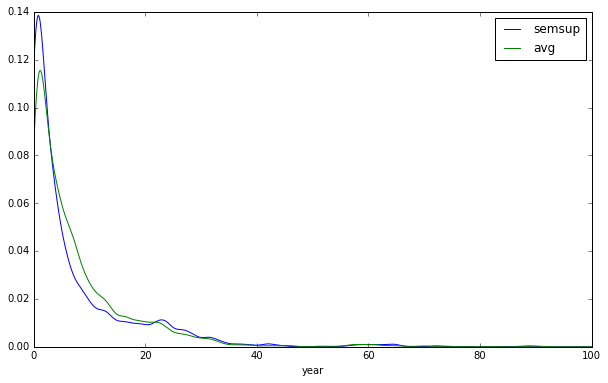

In [73]:
from sklearn.neighbors import KernelDensity

def plot_kde(diff, label=''):
    kde = KernelDensity()
    kde.fit(diff.reshape((-1, 1)))
    x = np.linspace(0, 100, 1000).reshape((-1, 1))
    score = kde.score_samples(x)
    
    plt.xlabel('year')
    
    return plt.plot(x.ravel(), np.exp(score.ravel()), label=label)
    
plot_kde(r1, 'semsup')
plot_kde(r2, 'avg')
plt.legend()

Тут из линейного программирование, пишет данные в формате lp. Работает долго. 

In [93]:
import pulp

class LinearProgrammingSolver(object):
    def __init__(self, G, demography, labeled_nodes, 
                 weighter):
        self.G = G
        self.demography = demography
        self.labeled_nodes = labeled_nodes
        self.weighter = weighter
        
        years = sorted(set(demography.ix[labeled_nodes, 'birth_year']))
        self.year_to_id = dict(zip(years, range(len(years))))
        self.id_to_year = dict(enumerate(years))
        
    def prepare_lp(self):
        G = self.G
        year_to_id = self.year_to_id  
        demography = self.demography
        
        labeled_nodes_set = set(self.labeled_nodes)
        
        num_labels = len(year_to_id)
        num_edges = G.number_of_edges()
        num_nodes = G.number_of_nodes()
                
        prob = pulp.LpProblem("Labelled graph problem", pulp.LpMinimize)    
        
        x_pa = pulp.LpVariable.dicts('x_pa', [(node, label) for node in range(num_nodes) 
                                            for label in range(num_labels)],                                  
                                  0., 1.)
        
        z_e = pulp.LpVariable.dicts('z_e', [edge for edge in range(num_edges)])
        z_ea = pulp.LpVariable.dicts('z_ea', [(edge, label) for edge in range(num_edges) 
                                                for label in range(num_labels)])
        
        condition = 0
        for node in G.nodes():
            if node in labeled_nodes_set:
                year = demography.ix[node]['birth_year']                
                condition += pulp.lpSum([x_pa[(node, label)] for label in range(num_labels) 
                                              if year_to_id[year] != label])

        for edge, (f, t, data) in enumerate(G.edges(data=True)):
            w = data['attr']
            if (f in labeled_nodes_set) and (t in labeled_nodes_set):
                (year_f, year_t) = demography.ix[f]['birth_year'], demography.ix[t]['birth_year']
                diff = np.abs(year_f - year_t)
                condition += z_e[edge] * ( 10. if diff < 4 else np.max(1. - diff / 10., 0.2) )
            else:
                condition += z_e[edge] * self.weighter((f, t, w)) 
        
        prob += condition 
        for node in G.nodes():
            prob += (pulp.lpSum([x_pa[(node, label)] for label in range(num_labels)]) == 1.)
                
        for edge, (f, t) in enumerate(G.edges()):
            prob += (0.5 * pulp.lpSum([z_ea[(edge, label)] for label in range(num_labels)]) == z_e[edge])
            
            for label in range(num_labels):
                prob += (z_ea[(edge, label)] >= x_pa[(f, label)] - x_pa[(t, label)])
                prob += (z_ea[(edge, label)] >= x_pa[(t, label)] - x_pa[(f, label)])
        
        
        return prob 
    #prob.writeLP("problem.lp")

In [94]:
lp_p = LinearProgrammingSolver(G, demography, tests[0][0], weighter)
aaaa = lp_p.prepare_lp()

In [ ]:
aaaa.solve()

In [90]:
pulp.LpProblem.solve(aaaa)

TypeError: unbound method solve() must be called with LpProblem instance as first argument (got str instance instead)